# FloPy

### MT3D-USGS Example

Demonstrates functionality of the flopy MT3D-USGS module using the 'Crank-Nicolson' example distributed with MT3D-USGS.  

#### Problem description:

* Grid dimensions: 1 Layer, 3 Rows, 650 Columns
* Stress periods: 3
* Units are in seconds and meters
* Flow package: UPW
* Stress packages: SFR, GHB
* Solvers: NWT, GCG

In [1]:
%matplotlib inline
import sys
import os
import platform
import string
from io import StringIO, BytesIO
import math
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

# run installed version of flopy or add local path
try:
    import flopy
except:
    fpth = os.path.abspath(os.path.join('..', '..'))
    sys.path.append(fpth)
    import flopy

print(sys.version)
print('numpy version: {}'.format(np.__version__))
print('matplotlib version: {}'.format(mpl.__version__))
print('flopy version: {}'.format(flopy.__version__))

3.6.1 |Continuum Analytics, Inc.| (default, May 11 2017, 13:04:09) 
[GCC 4.2.1 Compatible Apple LLVM 6.0 (clang-600.0.57)]
numpy version: 1.13.1
matplotlib version: 2.0.2
flopy version: 3.2.8


In [2]:
modelpth = os.path.join('data')
modelname = 'CrnkNic'
mfexe = 'mfnwt'
mtexe = 'mt3dusgs'
if platform.system() == 'Windows':
    mfexe += '.exe'
    mtexe += '.exe'

# Make sure modelpth directory exists
if not os.path.exists(modelpth):
    os.mkdir(modelpth)

# Instantiate MODFLOW object in flopy
mf = flopy.modflow.Modflow(modelname=modelname, exe_name=mfexe, model_ws=modelpth, version='mfnwt')

Set up model discretization

In [3]:
Lx = 650.0 
Ly = 15
nrow = 3
ncol = 650
nlay = 1

delr = Lx / ncol
delc = Ly / nrow

xmax = ncol * delr
ymax = nrow * delc

X, Y = np.meshgrid(np.linspace(delr / 2, xmax - delr / 2, ncol),    
                   np.linspace(ymax - delc / 2, 0 + delc / 2, nrow))


Instantiate output control (oc) package for MODFLOW-NWT

In [4]:
# Output Control: Create a flopy output control object
oc = flopy.modflow.ModflowOc(mf)                      

Instantiate solver package for MODFLOW-NWT

In [5]:
# Newton-Rhapson Solver: Create a flopy nwt package object

headtol = 1.0E-4 
fluxtol = 5      
maxiterout = 5000
thickfact = 1E-06
linmeth = 2      
iprnwt = 1       
ibotav = 1       

nwt = flopy.modflow.ModflowNwt(mf, headtol=headtol, fluxtol=fluxtol, maxiterout=maxiterout,       
                               thickfact=thickfact, linmeth=linmeth, iprnwt=iprnwt, ibotav=ibotav,
                               options='SIMPLE')                                          


Instantiate discretization (DIS) package for MODFLOW-NWT

In [6]:
# The equations for calculating the ground elevation in the 1 Layer CrnkNic model.  
# Although Y isn't used, keeping it here for symetry

def topElev(X, Y):
    return 100. - (np.ceil(X)-1) * 0.03

grndElev = topElev(X, Y)
bedRockElev = grndElev - 3.

Steady = [False, False, False]                                                                  
nstp = [1, 1, 1]                                                                        
tsmult = [1., 1., 1.]

# Stress periods extend from (12AM-8:29:59AM); (8:30AM-11:30:59AM); (11:31AM-23:59:59PM)
perlen = [30600, 10800, 45000]                                                                    
                                                                                       
# Create the discretization object
# itmuni = 1 (seconds); lenuni = 2 (meters)
dis = flopy.modflow.ModflowDis(mf, nlay, nrow, ncol, nper=3, delr=delr, delc=delc,     
                               top=grndElev, botm=bedRockElev, laycbd=0, itmuni=1, lenuni=2,
                               steady=Steady, nstp=nstp, tsmult=tsmult, perlen=perlen) 


Instantiate upstream weighting (UPW) flow package for MODFLOW-NWT

In [7]:
# UPW parameters 
# UPW must be instantiated after DIS.  Otherwise, during the mf.write_input() procedures,   
# flopy will crash.


laytyp = 1   
layavg = 2   
chani = 1.0  
layvka = 1
iphdry = 0
hk = 0.1
hani = 1
vka = 1.
ss = 0.000001
sy = 0.20
hdry = -888

upw = flopy.modflow.ModflowUpw(mf, laytyp=laytyp, layavg=layavg, chani=chani, layvka=layvka,
                               ipakcb=53, hdry=hdry, iphdry=iphdry, hk=hk, hani=hani,
                               vka=vka, ss=ss, sy=sy)
                                 


Instantiate basic (BAS or BA6) package for MODFLOW-NWT

In [8]:
# Create a flopy basic package object                                               
def calc_strtElev(X, Y):             
    return 99.5 - (np.ceil(X)-1) * 0.0001

ibound = np.ones((nlay, nrow, ncol))
ibound[:,0,:] *= -1
ibound[:,2,:] *= -1

strtElev = calc_strtElev(X, Y)

bas = flopy.modflow.ModflowBas(mf, ibound=ibound, hnoflo=hdry, strt=strtElev)


Instantiate streamflow routing (SFR2) package for MODFLOW-NWT

In [9]:
# Streamflow Routing Package: Try and set up with minimal options in use
# 9 11 IFACE # Data Set 1: ISTCB1  ISTCB2

nstrm = ncol  
nss = 6       
const = 1.0   
dleak = 0.0001
istcb1 = -10  
istcb2 = 11   
isfropt = 1   

segment_data = None
channel_geometry_data = None
channel_flow_data = None
dataset_5 = None
reachinput = True


# The next couple of lines set up the reach_data for the 30x100 hypothetical model.
# Will need to adjust the row based on which grid discretization we're doing.
# Ensure that the stream goes down one of the middle rows of the model.

strmBed_Elev = 98.75 - (np.ceil(X[1,:])-1) * 0.0001

s1 = 'k,i,j,iseg,ireach,rchlen,strtop,slope,strthick,strhc1\n'
iseg = 0
irch = 0

for y in range(ncol):
    if y <= 37:
        if iseg == 0:
            irch = 1
        else:
            irch += 1
        iseg = 1
        strhc1 = 1.0e-10
    elif y <= 104:
        if iseg == 1:
            irch = 1
        else:
            irch += 1
        iseg = 2
        strhc1 = 1.0e-10
    elif y <= 280:
        if iseg == 2:
            irch = 1
        else:
            irch += 1
        iseg = 3
        strhc1 = 2.946219199e-6
    elif y <= 432:
        if iseg == 3:
            irch = 1
        else:
            irch += 1
        iseg = 4
        strhc1 = 1.375079882e-6
    elif y <= 618:
        if iseg == 4:
            irch = 1
        else:
            irch += 1
        iseg = 5
        strhc1 = 1.764700062e-6
    else:
        if iseg == 5:
            irch = 1
        else:
            irch += 1
        iseg = 6
        strhc1 = 1e-10
    
    # remember that lay, row, col need to be zero-based and are adjusted accordingly by flopy
    #    layer +  row      +      col     +       iseg      +      irch      +     rchlen      +            strtop          +       slope       +     strthick    +     strmbed K
    s1 += '0,{}'.format(1)
    s1 += ',{}'.format(y)
    s1 += ',{}'.format(iseg)
    s1 += ',{}'.format(irch)
    s1 += ',{}'.format(delr)
    s1 += ',{}'.format(strmBed_Elev[y])
    s1 += ',{}'.format(0.0001)
    s1 += ',{}'.format(0.50)
    s1 += ',{}\n'.format(strhc1)


if not os.path.exists('data'):
    os.mkdir('data')

fpth = os.path.join('data', 's1.csv')
f = open(fpth, 'w')
f.write(s1)
f.close()

dtype = [('k', '<i4'), ('i', '<i4'), ('j', '<i4'), ('iseg', '<i4'), 
         ('ireach', '<f8'), ('rchlen', '<f8'), ('strtop', '<f8'), 
         ('slope', '<f8'), ('strthick', '<f8'), ('strhc1', '<f8')]

if (sys.version_info > (3, 0)):
    f = open(fpth, 'rb')
else:
    f = open(fpth, 'r')

reach_data = np.genfromtxt(f, delimiter=',', names=True, dtype=dtype)
f.close()

s2 = "nseg,icalc,outseg,iupseg,nstrpts,   flow,runoff,etsw,pptsw,        roughch,        roughbk,cdpth,fdpth,awdth,bwdth,width1,width2\n \
      1,    1,     2,     0,      0, 0.0125,   0.0, 0.0,  0.0, 0.082078856000, 0.082078856000,  0.0,  0.0,  0.0,  0.0,   1.5,   1.5\n \
      2,    1,     3,     0,      0,    0.0,   0.0, 0.0,  0.0, 0.143806300000, 0.143806300000,  0.0,  0.0,  0.0,  0.0,   1.5,   1.5\n \
      3,    1,     4,     0,      0,    0.0,   0.0, 0.0,  0.0, 0.104569661821, 0.104569661821,  0.0,  0.0,  0.0,  0.0,   1.5,   1.5\n \
      4,    1,     5,     0,      0,    0.0,   0.0, 0.0,  0.0, 0.126990045841, 0.126990045841,  0.0,  0.0,  0.0,  0.0,   1.5,   1.5\n \
      5,    1,     6,     0,      0,    0.0,   0.0, 0.0,  0.0, 0.183322283828, 0.183322283828,  0.0,  0.0,  0.0,  0.0,   1.5,   1.5\n \
      6,    1,     0,     0,      0,    0.0,   0.0, 0.0,  0.0, 0.183322283828, 0.183322283828,  0.0,  0.0,  0.0,  0.0,   1.5,   1.5"

fpth = os.path.join('data', 's2.csv')
f = open(fpth, 'w')
f.write(s2)
f.close()

if (sys.version_info > (3, 0)):
    f = open(fpth, 'rb')
else:
    f = open(fpth, 'r')

segment_data = np.genfromtxt(f, delimiter=',',names=True)
f.close()

# Be sure to convert segment_data to a dictionary keyed on stress period.
segment_data = np.atleast_1d(segment_data)                                                                                                                                                   
segment_data = {0: segment_data,                                                                                                                                                             
                1: segment_data,
                2: segment_data}
                                                                                                                                                                                             
# There are 3 stress periods
dataset_5 = {0: [nss, 0, 0],
             1: [nss, 0, 0],
             2: [nss, 0, 0]}
 
sfr = flopy.modflow.ModflowSfr2(mf, nstrm=nstrm, nss=nss, const=const, dleak=dleak, isfropt=isfropt, istcb2=0,
                                reachinput=True, reach_data=reach_data, dataset_5=dataset_5,
                                segment_data=segment_data, channel_geometry_data=channel_geometry_data)


/Users/jeremyw/miniconda3/lib/python3.6/site-packages/numpy/core/records.py:507: FutureWarning: Numpy has detected that you may be viewing or writing to an array returned by selecting multiple fields in a structured array. 

This code may break in numpy 1.13 because this will return a view instead of a copy -- see release notes for details.
  return obj.view(dtype=(self.dtype.type, obj.dtype))


Instantiate gage package for use with MODFLOW-NWT package

In [10]:
gages = [[1,38,61,1],[2,67,62,1], [3,176,63,1], [4,152,64,1], [5,186,65,1], [6,31,66,1]]
files = ['CrnkNic.gage','CrnkNic.gag1','CrnkNic.gag2','CrnkNic.gag3','CrnkNic.gag4','CrnkNic.gag5',
         'CrnkNic.gag6']
gage = flopy.modflow.ModflowGage(mf, numgage=6, gage_data=gages, filenames = files)

Instantiate streamflow routing (SFR2) package for MODFLOW-NWT

In [11]:
lmt = flopy.modflow.ModflowLmt(mf, output_file_name='CrnkNic.ftl', output_file_header='extended',
                               output_file_format='formatted', package_flows = ['sfr'])

Write the MODFLOW input files

In [12]:
pth = os.getcwd()
print(pth)

mf.write_input()

# run the model
mf.run_model()

/Users/jeremyw/Dev/flopy/examples/Notebooks
FloPy is using the following executable to run the model: /Users/jeremyw/bin/mfnwt

                                  MODFLOW-NWT-SWR1 
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUNDWATER-FLOW MODEL
                             WITH NEWTON FORMULATION
                             Version 1.1.3, 8/01/2017                        
                    BASED ON MODFLOW-2005 Version 1.11.0 08/08/2013                       

                    SWR1 Version 1.04.0 09/15/2016                       

 Using NAME file: CrnkNic.nam 
 Run start date and time (yyyy/mm/dd hh:mm:ss): 2018/01/05 13:55:37

 Solving:  Stress period:     1    Time step:     1    Groundwater-Flow Eqn.
 Solving:  Stress period:     2    Time step:     1    Groundwater-Flow Eqn.
 Solving:  Stress period:     3    Time step:     1    Groundwater-Flow Eqn.
 Run end date and time (yyyy/mm/dd hh:mm:ss): 2018/01/05 13:55:37
 Elapsed run time:  0.058 Seconds

  Normal termi

/Users/jeremyw/miniconda3/lib/python3.6/site-packages/numpy/core/records.py:507: FutureWarning: Numpy has detected that you may be viewing or writing to an array returned by selecting multiple fields in a structured array. 

This code may break in numpy 1.13 because this will return a view instead of a copy -- see release notes for details.
  return obj.view(dtype=(self.dtype.type, obj.dtype))


(True, [])

Now draft up MT3D-USGS input files.  

In [13]:
# Instantiate MT3D-USGS object in flopy
mt = flopy.mt3d.Mt3dms(modflowmodel=mf, modelname=modelname, model_ws=modelpth,
                       version='mt3d-usgs', namefile_ext='mtnam', exe_name=mtexe,
                       ftlfilename='CrnkNic.ftl', ftlfree=True)

Instantiate basic transport (BTN) package for MT3D-USGS

In [14]:
btn = flopy.mt3d.Mt3dBtn(mt, sconc=3.7, ncomp=1, prsity=0.2, cinact=-1.0, 
                         thkmin=0.001, nprs=-1, nprobs=10, chkmas=True, 
                         nprmas=10, dt0=180, mxstrn=2500)

Instantiate advection (ADV) package for MT3D-USGS

In [15]:
adv = flopy.mt3d.Mt3dAdv(mt, mixelm=0, percel=1.00, mxpart=5000, nadvfd=1)

Instatiate generalized conjugate gradient solver (GCG) package for MT3D-USGS

In [16]:
rct = flopy.mt3d.Mt3dRct(mt,isothm=0,ireact=100,igetsc=0,rc1=0.01)

In [17]:
gcg = flopy.mt3d.Mt3dGcg(mt, mxiter=10, iter1=50, isolve=3, ncrs=0,
                   accl=1, cclose=1e-6, iprgcg=1)

Instantiate source-sink mixing (SSM) package for MT3D-USGS

In [18]:
# For SSM, need to set the constant head boundary conditions to the ambient concentration
# for all 1,300 constant head boundary cells.

itype = flopy.mt3d.Mt3dSsm.itype_dict()
ssm_data = {}
ssm_data[0] = [(0, 0, 0, 3.7, itype['CHD'])]
ssm_data[0].append((0, 2, 0, 3.7, itype['CHD']))
for i in [0,2]:
    for j in range(1, ncol):
        ssm_data[0].append((0, i, j, 3.7, itype['CHD']))

ssm = flopy.mt3d.Mt3dSsm(mt, stress_period_data=ssm_data)


Instantiate streamflow transport (SFT) package for MT3D-USGS

In [19]:
dispsf = []
for y in range(ncol):
    if y <= 37:
        dispsf.append(0.12)
    elif y <= 104:
        dispsf.append(0.15)
    elif y <= 280:
        dispsf.append(0.24)
    elif y <= 432:
        dispsf.append(0.31)
    elif y <= 618:
        dispsf.append(0.40)
    else:
        dispsf.append(0.40)

# Enter a list of the observation points
# Each observation is taken as the last reach within the first 5 segments

seg_len = np.unique(reach_data['iseg'], return_counts=True)
obs_sf = np.cumsum(seg_len[1])
obs_sf = obs_sf.tolist()

# The last reach is not an observation point, therefore drop
obs_sf.pop(-1)

# In the first and last stress periods, concentration at the headwater is 3.7
sf_stress_period_data = {0: [0, 0, 3.7],
                         1: [0, 0, 11.4],
                         2: [0, 0, 3.7]}

gage_output = [None, None, 'CrnkNic.sftobs']

sft = flopy.mt3d.Mt3dSft(mt, nsfinit=650, mxsfbc=650, icbcsf=81, ioutobs=82,
                         isfsolv=1, cclosesf=1.0E-6, mxitersf=10, crntsf=1.0, iprtxmd=0,
                         coldsf=3.7, dispsf=dispsf, nobssf=5, obs_sf=obs_sf,
                         sf_stress_period_data = sf_stress_period_data,
                         filenames=gage_output)

sft.dispsf[0].format.fortran = "(10E15.6)"

Write the MT3D-USGS input files

In [20]:
mt.write_input()

# run the model
mt.run_model()

FloPy is using the following executable to run the model: /Users/jeremyw/bin/mt3dusgs

 MT3D-USGS - Modular 3D Multi-Species Transport Model [Ver 1.00.00] 
 and based on MT3DMS. MT3D-USGS developed in cooperation by 
 S.S. Papadopulos & Associates and the U.S. Geological Survey

 Using NAME File: CrnkNic.mtnam

 STRESS PERIOD NO.    1

 TIME STEP NO.    1
 FROM TIME =   0.0000     TO    30600.    

 Transport Step:    1   Step Size:   180.0     Total Elapsed Time:   180.00    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4865      [K,I,J]    1    2  289
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.5960E-07  [K,I,J]    1    1   36
 Outer Iter.  2  Inner Iter.  1:  Max. DC =   0.000      [K,I,J]    1    1    1
 Transport Step:    2   Step Size:   180.0     Total Elapsed Time:   360.00    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.9385      [K,I,J]    1    2  394
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1788E-06  [K,I,J]    1    2  294
 Outer Iter.  2  Inner Iter.  1:  Max.

 Outer Iter.  1  Inner Iter.  2:  Max. DC =   0.000      [K,I,J]    1    1    1
 Outer Iter.  2  Inner Iter.  1:  Max. DC =   0.000      [K,I,J]    1    1    1
 Transport Step:  107   Step Size:   180.0     Total Elapsed Time:   19260.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =   1.800      [K,I,J]    1    2  633
 Outer Iter.  1  Inner Iter.  2:  Max. DC =   0.000      [K,I,J]    1    1    1
 Outer Iter.  2  Inner Iter.  1:  Max. DC =   0.000      [K,I,J]    1    1    1
 Transport Step:  108   Step Size:   180.0     Total Elapsed Time:   19440.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =   1.800      [K,I,J]    1    2   31
 Outer Iter.  1  Inner Iter.  2:  Max. DC =   0.000      [K,I,J]    1    1    1
 Outer Iter.  2  Inner Iter.  1:  Max. DC =   0.000      [K,I,J]    1    1    1
 Transport Step:  109   Step Size:   180.0     Total Elapsed Time:   19620.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =   1.800      [K,I,J]    1    2   38
 Outer Iter.  1  Inner Iter.  2:  Max. D

 Outer Iter.  1  Inner Iter.  1:  Max. DC =   1.800      [K,I,J]    1    2   38
 Outer Iter.  1  Inner Iter.  2:  Max. DC =   0.000      [K,I,J]    1    1    1
 Outer Iter.  2  Inner Iter.  1:  Max. DC =   0.000      [K,I,J]    1    1    1
 Transport Step:   51   Step Size:   180.0     Total Elapsed Time:   39780.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =   1.800      [K,I,J]    1    2   29
 Outer Iter.  1  Inner Iter.  2:  Max. DC =   0.000      [K,I,J]    1    1    1
 Outer Iter.  2  Inner Iter.  1:  Max. DC =   0.000      [K,I,J]    1    1    1
 Transport Step:   52   Step Size:   180.0     Total Elapsed Time:   39960.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =   1.800      [K,I,J]    1    2  635
 Outer Iter.  1  Inner Iter.  2:  Max. DC =   0.000      [K,I,J]    1    1    1
 Outer Iter.  2  Inner Iter.  1:  Max. DC =   0.000      [K,I,J]    1    1    1
 Transport Step:   53   Step Size:   180.0     Total Elapsed Time:   40140.    
 Outer Iter.  1  Inner Iter.  1:  Max. D

 Transport Step:   63   Step Size:   180.0     Total Elapsed Time:   52740.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =   1.800      [K,I,J]    1    2   39
 Outer Iter.  1  Inner Iter.  2:  Max. DC =   0.000      [K,I,J]    1    1    1
 Outer Iter.  2  Inner Iter.  1:  Max. DC =   0.000      [K,I,J]    1    1    1
 Transport Step:   64   Step Size:   180.0     Total Elapsed Time:   52920.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =   1.800      [K,I,J]    1    2   50
 Outer Iter.  1  Inner Iter.  2:  Max. DC =   0.000      [K,I,J]    1    1    1
 Outer Iter.  2  Inner Iter.  1:  Max. DC =   0.000      [K,I,J]    1    1    1
 Transport Step:   65   Step Size:   180.0     Total Elapsed Time:   53100.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =   1.800      [K,I,J]    1    2   50
 Outer Iter.  1  Inner Iter.  2:  Max. DC =   0.000      [K,I,J]    1    1    1
 Outer Iter.  2  Inner Iter.  1:  Max. DC =   0.000      [K,I,J]    1    1    1
 Transport Step:   66   Step Size:   180

 Outer Iter.  2  Inner Iter.  1:  Max. DC =   0.000      [K,I,J]    1    1    1
 Transport Step:  138   Step Size:   180.0     Total Elapsed Time:   66240.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =   1.800      [K,I,J]    1    2   31
 Outer Iter.  1  Inner Iter.  2:  Max. DC =   0.000      [K,I,J]    1    1    1
 Outer Iter.  2  Inner Iter.  1:  Max. DC =   0.000      [K,I,J]    1    1    1
 Transport Step:  139   Step Size:   180.0     Total Elapsed Time:   66420.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =   1.800      [K,I,J]    1    2   31
 Outer Iter.  1  Inner Iter.  2:  Max. DC =   0.000      [K,I,J]    1    1    1
 Outer Iter.  2  Inner Iter.  1:  Max. DC =   0.000      [K,I,J]    1    1    1
 Transport Step:  140   Step Size:   180.0     Total Elapsed Time:   66600.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =   1.800      [K,I,J]    1    2   32
 Outer Iter.  1  Inner Iter.  2:  Max. DC =   0.000      [K,I,J]    1    1    1
 Outer Iter.  2  Inner Iter.  1:  Max. D

 Outer Iter.  1  Inner Iter.  1:  Max. DC =   1.800      [K,I,J]    1    2   40
 Outer Iter.  1  Inner Iter.  2:  Max. DC =   0.000      [K,I,J]    1    1    1
 Outer Iter.  2  Inner Iter.  1:  Max. DC =   0.000      [K,I,J]    1    1    1
 Transport Step:  213   Step Size:   180.0     Total Elapsed Time:   79740.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =   1.800      [K,I,J]    1    2  637
 Outer Iter.  1  Inner Iter.  2:  Max. DC =   0.000      [K,I,J]    1    1    1
 Outer Iter.  2  Inner Iter.  1:  Max. DC =   0.000      [K,I,J]    1    1    1
 Transport Step:  214   Step Size:   180.0     Total Elapsed Time:   79920.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =   1.800      [K,I,J]    1    2   41
 Outer Iter.  1  Inner Iter.  2:  Max. DC =   0.000      [K,I,J]    1    1    1
 Outer Iter.  2  Inner Iter.  1:  Max. DC =   0.000      [K,I,J]    1    1    1
 Transport Step:  215   Step Size:   180.0     Total Elapsed Time:   80100.    
 Outer Iter.  1  Inner Iter.  1:  Max. D

(False, [])

# Compare mt3d-usgs results to an analytical solution

In [21]:
# Define a function to read SFT output file
def load_ts_from_SFT_output(fname, nd=1):
    f=open(fname, 'r')
    iline=0
    lst = []
    for line in f:
        if line.strip().split()[0].replace(".", "", 1).isdigit():
            l = line.strip().split()
            t = float(l[0])
            loc = int(l[1])
            conc = float(l[2])
            if(loc == nd):
                lst.append( [t,conc] )
                
    ts = np.array(lst)
    f.close()
    return ts

# Also define a function to read OTIS output file
def load_ts_from_otis(fname, iobs=1):
    f = open(fname,'r')
    iline = 0
    lst = []
    for line in f:
        l = line.strip().split()
        t = float(l[0])
        val = float(l[iobs])
        lst.append( [t, val] )  
    
    ts = np.array(lst)
    f.close()
    return ts


Load output from SFT as well as from the OTIS solution

In [22]:
# Model output
fname_SFTout = os.path.join('data', 'CrnkNic.sftcobs.out')

# Loading MT3D-USGS output
ts1_mt3d = load_ts_from_SFT_output(fname_SFTout, nd=38) 
ts2_mt3d = load_ts_from_SFT_output(fname_SFTout, nd=105) 
ts3_mt3d = load_ts_from_SFT_output(fname_SFTout, nd=281)
ts4_mt3d = load_ts_from_SFT_output(fname_SFTout, nd=433)
ts5_mt3d = load_ts_from_SFT_output(fname_SFTout, nd=619)

# OTIS results located here
fname_OTIS = os.path.join('..', 'data', 'mt3d_test', 'mfnwt_mt3dusgs', 'sft_crnkNic', 'OTIS_solution.out')

# Loading OTIS output
ts1_Otis = load_ts_from_otis(fname_OTIS, 1)
ts2_Otis = load_ts_from_otis(fname_OTIS, 2)
ts3_Otis = load_ts_from_otis(fname_OTIS, 3)
ts4_Otis = load_ts_from_otis(fname_OTIS, 4)
ts5_Otis = load_ts_from_otis(fname_OTIS, 5)

Set up some plotting functions

In [23]:
def set_plot_params():
    import matplotlib as mpl
    from matplotlib.font_manager import FontProperties
    mpl.rcParams['font.sans-serif']          = 'Arial'
    mpl.rcParams['font.serif']               = 'Times'
    mpl.rcParams['font.cursive']             = 'Zapf Chancery'
    mpl.rcParams['font.fantasy']             = 'Comic Sans MS'
    mpl.rcParams['font.monospace']           = 'Courier New'
    mpl.rcParams['pdf.compression']          = 0
    mpl.rcParams['pdf.fonttype']             = 42
    
    ticksize = 10
    mpl.rcParams['legend.fontsize']  = 7
    mpl.rcParams['axes.labelsize']   = 12
    mpl.rcParams['xtick.labelsize']  = ticksize
    mpl.rcParams['ytick.labelsize']  = ticksize
    return

def set_sizexaxis(a,fmt,sz):
    success = 0
    x = a.get_xticks()
#   print x
    xc = np.chararray(len(x), itemsize=16)
    for i in range(0,len(x)):
        text = fmt % ( x[i] )
        xc[i] = string.strip(string.ljust(text,16))
#   print xc
    a.set_xticklabels(xc, size=sz)
    success = 1
    return success

def set_sizeyaxis(a,fmt,sz):
    success = 0
    y = a.get_yticks()
#   print y
    yc = np.chararray(len(y), itemsize=16)
    for i in range(0,len(y)):
        text = fmt % ( y[i] )
        yc[i] = string.strip(string.ljust(text,16))
#   print yc
    a.set_yticklabels(yc, size=sz)
    success = 1
    return success


Compare output:

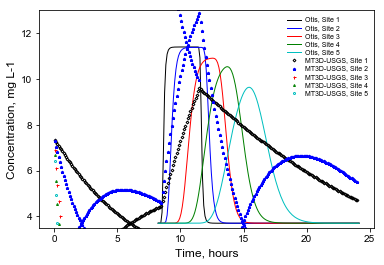

In [24]:
#set up figure
try:
    plt.close('all')
except:
    pass

set_plot_params()

fig = plt.figure(figsize=(6, 4), facecolor='w')
ax = fig.add_subplot(1, 1, 1)

ax.plot(ts1_Otis[:,0], ts1_Otis[:,1], 'k-', linewidth=1.0)
ax.plot(ts2_Otis[:,0], ts2_Otis[:,1], 'b-', linewidth=1.0)
ax.plot(ts3_Otis[:,0], ts3_Otis[:,1], 'r-', linewidth=1.0)
ax.plot(ts4_Otis[:,0], ts4_Otis[:,1], 'g-', linewidth=1.0)
ax.plot(ts5_Otis[:,0], ts5_Otis[:,1], 'c-', linewidth=1.0)

ax.plot((ts1_mt3d[:,0])/3600, ts1_mt3d[:,1], 'kD', markersize=2.0, mfc='none',mec='k')
ax.plot((ts2_mt3d[:,0])/3600, ts2_mt3d[:,1], 'b*', markersize=3.0, mfc='none',mec='b')
ax.plot((ts3_mt3d[:,0])/3600, ts3_mt3d[:,1], 'r+', markersize=3.0)
ax.plot((ts4_mt3d[:,0])/3600, ts4_mt3d[:,1], 'g^', markersize=2.0, mfc='none',mec='g')
ax.plot((ts5_mt3d[:,0])/3600, ts5_mt3d[:,1], 'co', markersize=2.0, mfc='none',mec='c')

#customize plot
ax.set_xlabel('Time, hours')
ax.set_ylabel('Concentration, mg L-1')
ax.set_ylim([3.5,13])
ticksize = 10

#legend
leg = ax.legend(
                (
                 'Otis, Site 1', 'Otis, Site 2', 'Otis, Site 3', 'Otis, Site 4', 'Otis, Site 5',
                 'MT3D-USGS, Site 1', 'MT3D-USGS, Site 2', 'MT3D-USGS, Site 3', 'MT3D-USGS, Site 4', 'MT3D-USGS, Site 5',
                 ), 
                loc='upper right', labelspacing=0.25, columnspacing=1,
                handletextpad=0.5, handlelength=2.0, numpoints=1)
leg._drawFrame = False 

plt.show()